In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [ ]:
def bootstrap_test(
    s1,
    s2,
    n_ss=5000,
    statistic_func=np.mean,
    conf_level=0.95,
    hist_n_bins=100,
    p_val_evaluation=False,
    print_info=True
):
    '''
    Функция для проверки гипотез с помощью bootstrap

    Parameters
    ----------
    s1: pandas.Series
        Выборка 1
    s2: pandas.Series
        Выборка 2
    n_ss: int, default 5000
        Количество bootstrap подвыборок (bootstrab subsamples)
        bootstrap подвыборка - подвыборка с повторениями
    statistic_func: function, default np.mean
        Функция для вычисления интересующей статистики
    conf_level: float, default 0.95
        Уровень значимости
    hist_n_bins: int, default 100
        Количество столбиков для гистограммы
    p_val_evaluation: bool, default False
        Оценка p-value с помощью нормального распределения
    print_info: bool, default True
        Вывод на экран информации (в т.ч. красивого графика)

    Returns
    -------
    is_0_in_ci: bool
        Находится ли 0 в ДИ
    boot_data: pandas.Series
        Расрпределение разницы метрик бутстрап выборок
    quantiles: dict
        Словарь с квантилями
    '''
    # Размер бутстрап подвыборок
    ss1_size = len(s1)
    ss2_size = len(s2)

    # Распределение разницы статистик подвыборок
    boot_data = []
    if print_info:
        for i in tqdm(range(n_ss)):  # извлекаем подвыборки
            ss1 = s1.sample(ss1_size, replace=True).values
            ss2 = s2.sample(ss2_size, replace=True).values
            boot_data.append(statistic_func(ss1)-statistic_func(ss2))
    else:
        for i in range(n_ss):  # извлекаем подвыборки
            ss1 = s1.sample(ss1_size, replace=True).values
            ss2 = s2.sample(ss2_size, replace=True).values
            boot_data.append(statistic_func(ss1)-statistic_func(ss2))

    boot_data = pd.Series(boot_data)

    # Вычисление квантилей
    left_quant = (1 - conf_level) / 2
    right_quant = 1 - left_quant
    quantiles = boot_data.quantile([left_quant, right_quant])
    quantiles.columns = ['value']

    # Статзначимость отличий выборок
    if quantiles.iloc[0] < 0 <= quantiles.iloc[1]:
        is_0_in_ci = True
    else:
        is_0_in_ci = False

    # Вычисление p-value
    # (из предположения, что распределение разницы статистик подвыборок - нормальное)
    if p_val_evaluation:
        p_1 = st.norm.cdf(
            x=0,
            loc=boot_data.mean(),
            scale=boot_data.std()
        )
        p_2 = st.norm.cdf(
            x=0,
            loc=-boot_data.mean(),
            scale=boot_data.std()
        )
        p_value = min(p_1, p_2) * 2  # Двустороння вероятность нулевых отличий распределений

    # Визуализация
    if print_info:
        hist_ys = []
        _, _, bars = plt.hist(boot_data, bins=hist_n_bins)
        for bar in bars:
            hist_ys.append(bar.get_height())
            bar.set_edgecolor('black')
            if quantiles.iloc[0] < bar.get_x() <= quantiles.iloc[1]:
                # Столбик в ДИ
                bar.set_facecolor('grey')
            else:
                bar.set_facecolor('red')
        plt.style.use('ggplot')
        plt.vlines(quantiles, ymin=0, ymax=max(hist_ys), linestyle='--', colors='black')  # Отображение квантилей
        if quantiles.iloc[0] < 0 <= quantiles.iloc[1]:  # Подсветка нуля
            plt.vlines(0, ymin=0, ymax=max(hist_ys), colors='green')
        else:
            plt.vlines(0, ymin=0, ymax=max(hist_ys), colors='red')
        plt.xlabel('metric difference')
        plt.ylabel('frequency')
        plt.title("Subsamples metric difference")
        plt.show()
        if p_val_evaluation:
            print(f'p-value: {p_value}')

    return is_0_in_ci, boot_data, quantiles

#### Вероятность ошибки 1го рода с указанным исходными данными

 Используется распределение, сходное с распределением средних чеков

In [ ]:
n = 1000     # Количество наблюдений распределения
scale = 100  # МО

In [ ]:
s1 = pd.DataFrame({  # Выборка 1
    'observations': np.random.exponential(scale=scale, size=n),
    'sample': '1'
})
s2 = pd.DataFrame({  # Выборка 2
    'observations': np.random.exponential(scale=scale, size=n),
    'sample': '2'
})
df = pd.concat([s1, s2]).reset_index(drop=True)

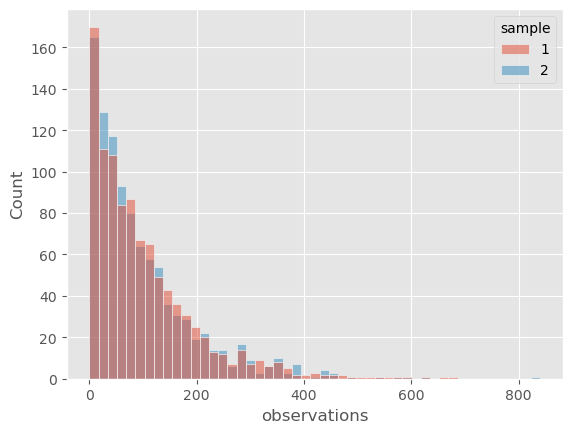

In [ ]:
sns.histplot(data=df, x='observations', hue='sample');

  0%|          | 0/5000 [00:00<?, ?it/s]

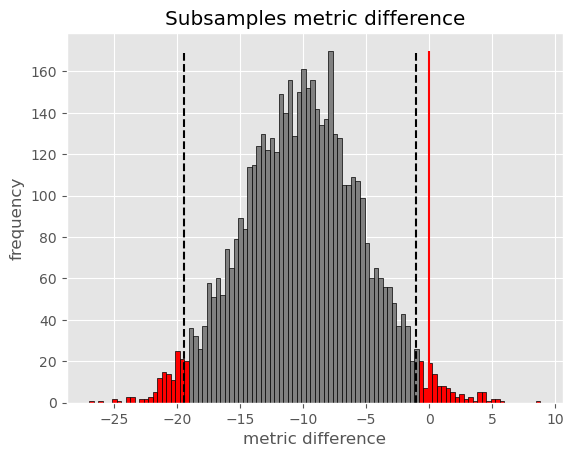

In [ ]:
_ = bootstrap_test(
    df.query('sample == "1"').observations,
    df.query('sample == "2"').observations
)

In [ ]:
N = 300  # Количество синтетических тестов

In [ ]:
is_0_in_ci_statistic = []
for i in tqdm(range(N)):
    s1 = pd.Series(np.random.exponential(scale=scale, size=n))  # Выборка 1
    s2 = pd.Series(np.random.exponential(scale=scale, size=n))  # Выборка 2

    is_0_in_ci_statistic.append(bootstrap_test(
        s1,
        s2,
        n_ss=5000,
        statistic_func=np.mean,
        conf_level=0.95,
        hist_n_bins=100,
        p_val_evaluation=False,
        print_info=False
    )[0])

err_rate = (N - sum(is_0_in_ci_statistic)) / N
print(f'err_rate = {round(err_rate*100, 2)} %')

  0%|          | 0/300 [00:00<?, ?it/s]

err_rate = 5.0 %


#### Вероятность ошибки 2го рода с указанным исходными данными

In [ ]:
d_scale = 10  # % Отличия МО

s1 = pd.DataFrame({  # Выборка 1
    'observations': np.random.exponential(scale=scale, size=n),
    'sample': '1'
})
s2 = pd.DataFrame({  # Выборка 2
    'observations': np.random.exponential(scale=scale*(1 + d_scale/100), size=n),
    'sample': '2'
})
df = pd.concat([s1, s2]).reset_index(drop=True)

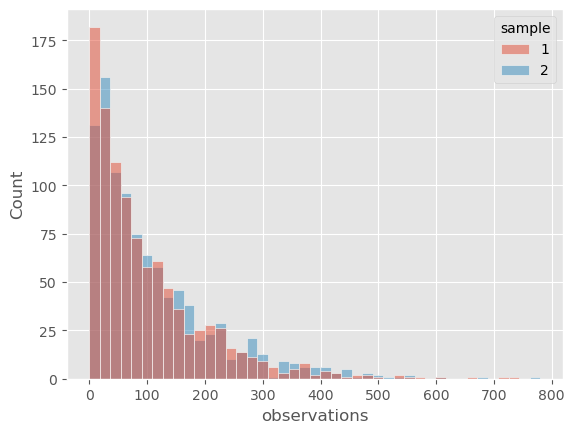

In [ ]:
sns.histplot(data=df, x='observations', hue='sample');

  0%|          | 0/5000 [00:00<?, ?it/s]

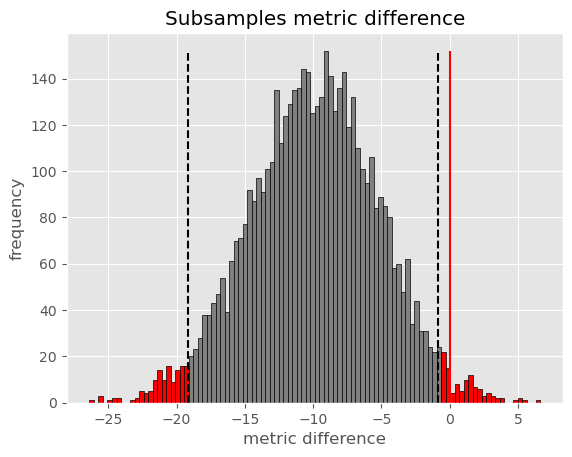

In [ ]:
_ = bootstrap_test(
    df.query('sample == "1"').observations,
    df.query('sample == "2"').observations
)

In [ ]:
is_0_in_ci_statistic = []
for i in tqdm(range(N)):
    s1 = pd.Series(np.random.exponential(scale=scale, size=n))  # Выборка 1
    s2 = pd.Series(np.random.exponential(scale=scale*(1 + d_scale/100)))  # Выборка 2

    is_0_in_ci_statistic.append(bootstrap_test(
        s1,
        s2,
        n_ss=5000,
        statistic_func=np.mean,
        conf_level=0.95,
        hist_n_bins=100,
        p_val_evaluation=False,
        print_info=False
    )[0])

err_rate = sum(is_0_in_ci_statistic) / N
print(f'err_rate = {round(err_rate*100, 2)} %')

  0%|          | 0/300 [00:00<?, ?it/s]

err_rate = 4.33 %


Inspired by: KCM7L9P

## Идеи по улучшению:
- расчёт p-value
- полноценный расчёт матрицы ошибок
- оценка mde
- сравнение эффективности с другими тестами

#### Наброски для расчёта p-value по дискретному распределению

In [ ]:
def find_interval(array, value):
    """
    Функция ищет интервал значений вокруг value и индексы границ интервала в array

    Parameters
    ----------
    array: array-like
        Отсортированный по возрастанию/убыванию массив с уникальными значениями
    value: float
        Значение, для которого необходимо найти охватывающий интервал из array

    Returns
    -------
    interval_found_flag: bool
        Флаг того, что интервал найден
    i: int
        Индекс элемента массива, являющегося левой границей в искомом интервале
    """
    interval_found_flag = False
    interval = 0

    n = len(array) - 1  # Последний элемент массива
    if value <= min(array) or value >= max(array):
        return interval_found_flag, interval
    if array[0] < array[1]:
        for i in range(n):
            if array[i] <= value <= array[i + 1]:
                interval_found_flag = True
                return interval_found_flag, i
    else:
        for i in range(n):
            if array[i] >= value >= array[i + 1]:
                interval_found_flag = True
                return interval_found_flag, i

In [ ]:
def find_discrete_p_value(
    sample,
    round_val=4
):
    """
    Функция для поиска p-value по дискретному распределению из sample

    Parameters
    ----------
    sample: array-like
        Массив, задающий дискретное распределение
    round_val: int, default 4
        Количество знаков после запятой для округления результата

    Returns
    -------
    p_value: float
        p-value
    """
    x, counts = np.unique(sample, return_counts=True)
    cumsum = np.cumsum(counts)
    value = 0
    interval_found_flag, i_a = find_interval(x, value)
    p_value = 0
    if interval_found_flag:
        if i_a >= len(x) / 2:
            p_value = (1 - cumsum[i_a] / cumsum[-1]) * 2
        else:
            p_value = cumsum[i_a + 1] / cumsum[-1] * 2

    return round(p_value, round_val)